In [125]:
import csv
import numpy as np
import pandas as pd
from tabulate import tabulate
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt
%cd /storage2/mwildi/CBS2

/storage2/mwildi/CBS2


In [202]:
#Plots data inside data_per_model
def plotter(data_per_model, main_title, legends, x_ticks, x_description, y_description, savepath):
    assert(len(legends)==data_per_model.shape[0])
    assert(len(x_ticks)==data_per_model.shape[1])

    metrics = pd.DataFrame(np.array([data_per_model[:,i] for i in range(len(x_ticks))]), columns=legends)
    ax = metrics.plot(kind='bar', figsize=(12, 7), legend=True, fontsize=16)
    ax.set_xlabel(x_description)
    x = np.arange(len(x_ticks))
    ax.set_xticks(x)
    ax.set_xticklabels(x_ticks, fontsize=16, rotation='horizontal')
    ax.set_ylabel(y_description, fontsize=16)
    plt.title(main_title, fontsize=20, weight='bold')
    plt.savefig(savepath)

In [258]:
#####################################################################################
# Parsing code adapted from World on Rails scripts/view_nocrash_results
#####################################################################################

def parse_results(path, traffic=None, metric_out=None):
    TOWNS = ['Town01', 'Town02']
    TRAFFICS = ['empty', 'regular', 'dense']
    WEATHERS = {
        1: 'train', 3: 'train', 6: 'train', 8: 'train',
        10: 'test', 14: 'test',
    }
    METRICS = ['Success Rate', 'Route Completion', 'Lights Ran ph', 'No Block', 'No Collision', 
               'No Collision Veh', 'No Collision Walk', 'RC When Collided']

    if traffic=='empty':
        TRAFFICS = ['empty']
    elif traffic=='regular':
        TRAFFICS = ['regular']
    elif traffic=='dense':
        TRAFFICS = ['dense']

    finished = defaultdict(lambda: [])

    with open(path+'.csv', 'r') as file:
        log = csv.DictReader(file)
        for row in log:
            finished[(
                row['town'],
                int(row['traffic']),
                WEATHERS[int(row['weather'])],
            )].append((
                float(row['route_completion']),
                int(row['lights_ran']),
                float(row['duration']),
                float(row['outside_lane']),
                str(row['collision']),
                str(row['collision_vehicle']),
                str(row['collision_walker']),
                str(row['in_route']),
                str(row['blocked'])
            ))

    all_stats=dict()
    
    for town, weather_set in product(TOWNS, set(WEATHERS.values())):

        output = "\n"
        output += "\033[1m========= Results of {}, weather {} \033[1m=========\033[0m\n".format(
                town, weather_set)
        output += "\n"
        list_statistics = [['Traffic', *TRAFFICS], [metric_out]+['N/A']*len(TRAFFICS),['Duration']+['N/A']*len(TRAFFICS)]

        all_stats[town+weather_set] = {}
        
        for metric in METRICS:
            stat= ['N/A']*len(TRAFFICS)

            for traffic_idx, traffic in enumerate(TRAFFICS):
                runs = finished[town,TRAFFICS.index(traffic),weather_set]

                if len(runs) > 0:
                    route_completion, lights_ran, duration, outside_lane, collision, collision_vehicle, collision_walker, in_route, blocked = zip(*runs)
                    mean_lights_ran = np.array(lights_ran)/np.array(duration)*3600

                    if metric == 'Success Rate':
                        stat[traffic_idx] = np.round(100*np.mean(np.array(route_completion)==100), 2)
                    elif metric == 'Route Completion':
                        stat[traffic_idx] = np.round(np.mean(route_completion), 2)
                    elif metric == 'Lights Ran ph':
                        stat[traffic_idx] = np.round(np.mean(mean_lights_ran), 2)
                    elif metric == 'No Block':
                        stat[traffic_idx] = np.round(100*blocked.count('SUCCESS')/len(blocked), 2)
                    elif metric == 'No Collision':
                        stat[traffic_idx] = round(100*collision.count('SUCCESS')/len(collision), 2)
                    elif metric == 'No Collision Veh':
                        stat[traffic_idx] = np.round(100*collision_vehicle.count('SUCCESS')/len(collision_vehicle), 2)
                    elif metric == 'No Collision Walk':
                        stat[traffic_idx] = np.round(100*collision_walker.count('SUCCESS')/len(collision_walker), 2)
                    elif metric == 'RC When Collided':
                        collided = [True if x=='FAILURE' else False for x in collision]
                        stat[traffic_idx] = np.round(np.mean(np.array(route_completion)[collided]), 2)

                    if metric == metric_out:
                        list_statistics[1][traffic_idx+1] = "{}%".format(stat[traffic_idx])
                    list_statistics[2][traffic_idx+1] = "{}s".format(round(np.mean(duration), 2))
                    
                all_stats[town+weather_set][metric] = stat
        output += tabulate(list_statistics, tablefmt='fancy_grid')
        output += "\n"
        if metric_out is not None:
            print(output)
    return all_stats

In [279]:
main_title = 'Directional command at intersection'
y_description = '[%] of dataset intersection frames'
savepath = 'Notebooks/plots/dataset/dataset_cmd.png'

plot_traffic=None
plot_config='Town02test'
plot_metric='No Block'

In [280]:
original=parse_results('results/final/test_original', plot_traffic)
ppm=parse_results('results/final/test_ppm', plot_traffic)
fpn=parse_results('results/final/test_ppm', plot_traffic)

In [281]:
#original

In [284]:
legends = ['Original', 'PPM', 'FPN']
#Comparison according to traffic
if plot_traffic == None:
    x_ticks = ['Empty', 'Regular', 'Dense']
    x_description = 'Traffic condition'
    data_original = original[plot_config][plot_metric]
    data_ppm = ppm[plot_config][plot_metric]
    data_fpn = fpn[plot_config][plot_metric]
#Comparison according to train/test
else:
    configs = ['Town02test', 'Town02test']
    x_ticks = ['Train', 'Test']
    x_description = 'Town and weather configuration'
    data_original = [original[config][plot_metric][0] for config in configs]
    data_ppm = [ppm[config][plot_metric][0] for config in configs]
    data_fpn = [fpn[config][plot_metric][0] for config in configs]  

data_per_model = np.vstack((data_original, data_ppm, data_fpn))
print(data_per_model)

[[52. 96. 98.]
 [62. 80. 92.]
 [62. 80. 92.]]


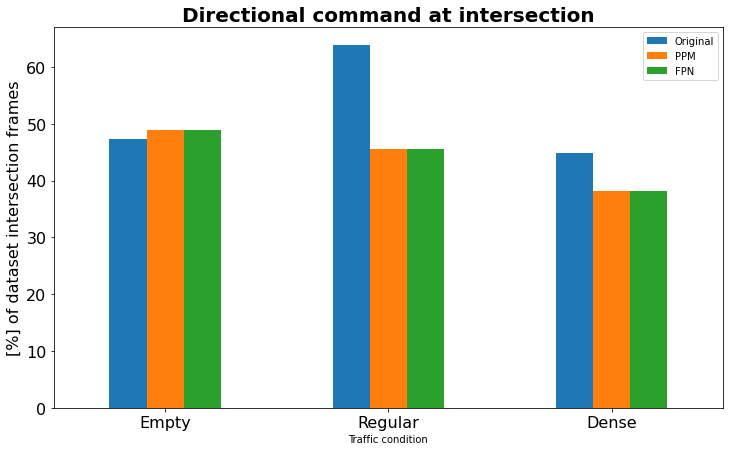

In [268]:
plotter(data_per_model, main_title, legends, x_ticks, x_description, y_description, savepath)